# FIT5201: Assessment 3
## Latent Variables and Neural Networks

### Student Name:  Ralph Gailis

### Student Number:  28838750

### Recording: [link](https://cloudstor.aarnet.edu.au/plus/s/Wls6pbB8oKahGhm) and passphrase:  wnb_icqLAA76

## Objectives
This assignment consists of three parts (A,B,C), which cover latent variables models and neural networks (Modules 4 and 5). The total marks of this assessment is 100.

## Important Note
* You can complete your assignment using the codes shared in the unit (ie Alexandria and Moodle) and this template as the bases. However, <font color='red'>**you should make sure the codes you are using are correct and relevant to the question**</font>.

* Please follow the structure of this template as much as you can.

* You can use the prepopulated codes cells or change them if you prefer. However, please do not change the name of the key variables, functions, and parameters eg `N`, `D`, and `eta`. It helps us to read and understand your submissiont more efficiently.

# Part A. Document Clustering
In this part, you solve a document clustering problem using unsupervised learning algorithms (i.e., soft and hard Expectation Maximization for document clustering.

## Question 1 [EM for Document Clustering, 40 Marks]

#### Background of the soft-EM and hard-EM

##### Soft EM  
  **E-Step**
  
  For each cluster $k$, based on its current mixing component $\varphi_k^{old}$, word proportion $\mu_k^{old}$, calculate the posterior probability of the nth document $d_n$ being in cluster $k$, denoted by $\gamma(z_{nk})$
  
  $\gamma(z_{nk}):= p(z_{nk} = 1 \mid d_n, \varphi_k^{old}, \mu_k^{old}) = \frac{\varphi_k^{old}\prod_{w \in \mathcal{A}}\mu_{k,w}^{c(w,d_n)}}{\sum_{j=1}^K\varphi_j^{old}\prod_{w \in \mathcal{A}}\mu_{j,w}^{c(w,d_n)}}$  
  
  **M-Step**
 
  Update the parameters as the following:
  
  mixing components: $\varphi_k^{new} = \frac{N_k}{N}$ where  $N_k = \sum_{n=1}^N \gamma(z_{nk})$  
  word proportion: $\mu_{k,w}^{new} = \frac{\sum_{n=1}^N\gamma(z_{nk})c(w,d_n)}{\sum_{w'\in \mathcal{A}}\sum_{n=1}^N\gamma(z_{nk})c(w',d_n)}$
  
  
##### Hard EM  
  **E-Step**

  For each cluster $k$, based on its current mixing component $\varphi_k^{old}$, word proportion $\mu_k^{old}$, calculate the posterior probability of the nth document $d_n$ being in cluster $k$, denoted by $\gamma(z_{nk})$
  
  $\gamma(z_{nk}):= p(z_{nk} = 1 \mid d_n, \varphi_k^{old}, \mu_k^{old}) = \frac{\varphi_k^{old}\prod_{w \in \mathcal{A}}\mu_{k,w}^{c(w,d_n)}}{\sum_{j=1}^K\varphi_j^{old}\prod_{w \in \mathcal{A}}\mu_{j,w}^{c(w,d_n)}}$  
  
  then set $\gamma_{nk^*}=1$ and everywhere else to 0, where $k^* \leftarrow argmax_k \gamma(z_{nk})$ 
  
  **M-Step**
  
  Update the parameters as the following:
    
  mixing components: $\varphi_k^{new} = \frac{N_k}{N}$ where $N_k = \sum_{n=1}^N \gamma(z_{nk})$  
  word proportion: $\mu_{k,w}^{new} = \frac{\sum_{n=1}^N\gamma(z_{nk})c(w,d_n)}{\sum_{w'\in \mathcal{A}}\sum_{n=1}^N\gamma(z_{nk})c(w',d_n)}$ 

### Q1-1 

Implement the hard-EM and soft-EM provided above. Please provide enough comments in your submitted code.

#### Implementing the posterior calculation
The posterior probability equation given above contains a product of small factors (the word proportions $\mu_{k,w}$ raised to powers of the word frequencies). Since there are many words, using standard double floating point arithmetic, the posterior probabilities will tend to be zero within machine precision when multiplying through by all the factors.  To execute the calculation, we first take the log of the numerator:

$$
    \log \gamma(z_{nk}) \propto \log \varphi_k + \sum_{w \in \mathcal{A}} c(w, d_n) \log \mu_{k,w}
$$

Then to normalise the probabilities over the classes to make them sum to one, for a given document $d_n$, we have an associated constant $A_n$ such that

$$
    \log A_n = - \log \left\{ \sum_{k=1}^K \exp \left[ \log \varphi_k + \sum_{w \in \mathcal{A}} c(w, d_n) \log \mu_{k,w}
        \right] \right\}
$$

Using the computational trick described at the blogpost https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/, we can maintain finite floating point numbers when calculating this equation by applying the identity

$$
    \log \left[ \sum_{k=1}^K \exp(x_k) \right] = a + \log \left[ \sum_{k=1}^K \exp(x_k - a) \right]
$$
where $a = \max_k x_k$.

This gives the value of the normalisation constant for each document as

$$
    \log A_n = -a_n - \log \left\{
        \sum_{k=1}^K \exp \left[ \log \varphi_k + \sum_{w \in \mathcal{A}} c(w, d_n) \log \mu_{k,w} - a_n \right] \right\}
$$

with $a_n$ the maximum of the expression in square brackets, i.e. the largest term in the sum. The final value of the posterior is then

$$
    \gamma(z_{nk}) = \exp \left\{ \log A_n + \log \varphi_k + \sum_{w \in \mathcal{A}} c(w, d_n) \log \mu_{k,w} \right\}
$$

All terms in this expression will be within the range of double floating point numbers within the computer.


In [1]:
#### Hard and soft clustered multinomial model for document clustering

# X is dataframe of data to cluster, K = number of clusters to form,
#   hardclustering(T/F) for hard(True) or soft(False) clustering
doc.clustering <- function(X, K, hardclustering=FALSE) {

    # data derived settings - like sizes
    N <- nrow(X)        # number of documents
    D <- ncol(X)        # number of words in dictionary
    # Setting the parameters:
    eta.max <- 100      # 100 # maximum number of iterations
    epsilon <- 0.01     # 0.01 # termination threshold
    tiny <- 1e-99       # small value to avoid 0 sum normalisation
    # Initialisations:
    eta <- 1            # epoch counter
    terminate <- FALSE  # termination condition

    # Random cluster initialisation:
    Phi.hat <- matrix(1/K, nrow = K)  # assume all clusters have the same size (we will update this later on)
    Nk.hat <- matrix(N/K, nrow = K)   # refer to the above line!
    
    # Mu is a matrix of dimensions K by D, where each row corresponds to the proportion of words in that cluster.
    # Each row must sum to 1.
    # Assign initial values randomly
    Mu.hat <- matrix(sample(1:D, K*D, replace = TRUE), nrow = K, ncol = D)
    Mu.hat <- Mu.hat / rowSums(Mu.hat)
    post <- matrix(, nrow=N, ncol=K)      # empty posterior matrix (the membership estimates will be stored here)
    log.post <- matrix(, nrow=N, ncol=K)  # empty log of posterior matrix, used to aid calculations of small factors

    # Build the the model
    Mu.hat.old <- Mu.hat  # store the old estimated means
    while (!terminate) {

        ### E step:
        # calculate the posterior given the observation of a given document
        # based on the word proportions - see equations above
        # loop over each document
        for (n in 1:N) {
            
            # loop over each cluster
            for (k in 1:K) {
                # apply calculation to log of the posterior to control small numbers
                log.post[n, k] <- log(Phi.hat[k]) + sum(X[n, ] * log(Mu.hat[k, ]))
            }
            
            # calculate a regularising term, that ensures temporary posterior calculation is finite
            a_n <- max(log.post[n, ])
            # use regularising term to calculate a normalisation constant for posterior
            log.A_n <- -a_n - log(sum(exp(log.post[n, ] - a_n)))
            # now transform from log of posterior to the actual posterior value - see equations above
            post[n, ] <- exp(log.A_n + log.post[n, ])
        }
        post[post < tiny] <- tiny  # ensure no zero values in post, otherwise we get NaN results
        
        # use function flag to decide between hard and soft cluster assignment
        if (hardclustering) {
            
            ## hard assignments:
            # for each point find the cluster with the maximum (estimated) probability
            max.prob <- post==apply(post, 1, max)
            post[max.prob] <- 1     # assign each point to the cluster with the highest probability
            post[!max.prob] <- tiny # remove points from clusters with lower probabilites
        }

        ### M step:
        for (k in 1:K) {
            ## recalculate the estimations:
            Nk.hat[k] <- sum(post[, k])        # the effective number of points in cluster k
            Phi.hat[k] <- Nk.hat[k] / N        # the relative cluster size
            Mu.hat[k, ] <- t(post[, k]) %*% X  # update Mu.hat according to equations (unnormalised)
            Mu.hat[k, ] <- Mu.hat[k, ] / sum(Mu.hat[k, ]) # normalise Mu.hat
        }

        # increase the epoch counter
        eta <- eta + 1

        # check the termination criteria
        terminate <- (eta > eta.max) | (sum(abs(Mu.hat.old - Mu.hat)) <= epsilon)

        # record the means (neccessary for checking the termination criteria)
        Mu.hat.old <- Mu.hat
    }
    
    # That's it! Let see how many iterations we had:
    cat('maximum number of iterations:', eta, '\n')
    return (post)
}

### Q1-2

Load __Task3A.text__ file and necessary libraries (if needed, perform text preprocessing similar to what we did in Activity 4.2), set the number of clusters K=4, and run both the soft-EM and hard-EM algorithms on the provided data.

In [2]:
# library imports
library(mvtnorm)  # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2)  # plotting
library(reshape2) # data wrangling!
library(tm)       # load Text Mining library
set.seed(12345)   # save the random seed to make the results reproducible

Warning message:
"package 'mvtnorm' was built under R version 3.4.1"Warning message:
"package 'ggplot2' was built under R version 3.4.4"Warning message:
"package 'reshape2' was built under R version 3.4.4"Warning message:
"package 'tm' was built under R version 3.4.1"Loading required package: NLP
Warning message:
"package 'NLP' was built under R version 3.4.1"
Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate



In [3]:
## Import data
## read the file (each line of the text file is one document)
text <- readLines('../Task3A.txt')

## the terms before '\t' are the labels (the newsgroup names) and all the remaining text after '\t' are the actual documents
docs <- strsplit(text, '\t')
rm(text) # just free some memory!

# store the labels for evaluation
labels <- unlist(lapply(docs, function(x) x[1]))
sample.size <- length(labels)

# store the unlabelled texts    
#docs <- data.frame(doc_id = 1:sample.size, text = unlist(lapply(docs, function(x) x[2])))
docs <- data.frame(unlist(lapply(docs, function(x) x[2])))

Examine how many labelled classes there are, so that we can select a reasonable value for $K$ in the clustering algorithm.

In [4]:
# see how many real classes we have
nlevels(factor(labels))

[1] 4

Now we load the text data and do some basic text preprocessing to develop a document term matrix with interesting words contained within it.

In [5]:
#### text pre-processing

# create a corpus
docs <- DataframeSource(docs)
docs <- Corpus(docs)

## Preprocessing:
# remove stop words (the most common word in a language that can be found in any document)
docs <- tm_map(docs, removeWords, stopwords("english")) 
docs <- tm_map(docs, removePunctuation) # remove punctuation
docs <- tm_map(docs, stemDocument)      # perform stemming (reducing inflected and derived words to their root form)
docs <- tm_map(docs, removeNumbers)     # remove all numbers
docs <- tm_map(docs, stripWhitespace)   # remove redundant spaces 

## Create a matrix which its rows are the documents and columns are the words. 
# Each number in Document Term Matrix shows the frequency of a word (colomn header) in a particular document (row title)
dtm <- DocumentTermMatrix(docs)

# reduce the sparcity of out dtm
dtm <- removeSparseTerms(dtm, 0.92)

# convert dtm to a matrix
m <- as.matrix(dtm)
rownames(m) <- 1:nrow(m)


In [6]:
dim(m)

[1] 2373  186

There are 2373 documents to cluster, and after text preprocessing, we are left with 186 distinct word stems.  Given that we originally found 4 labels, we will search for 4 clusters using the soft and hard expectation-maximisation algorithms.

In [7]:
K = 4   # search for 4 clusters
softpost <- doc.clustering(m, K, hardclustering=FALSE)  # apply soft EM algorithm to document clustering
hardpost <- doc.clustering(m, K, hardclustering=TRUE)   # apply hard EM algorithm to document clustering
max.soft.class <- max.col(softpost)  # class number with max probability in softpost

maximum number of iterations: 14 
maximum number of iterations: 23 


In [8]:
head(softpost)

1.000000e-99,1.000000e+00,1.000000e-99,6.439994e-24
1.000000e-99,1.000000e+00,1.000000e-99,2.730028e-25
8.301732e-81,1.000000e+00,1.000000e-99,7.848606e-24
9.973485e-01,2.053467e-04,4.569214e-04,1.989197e-03
9.933613e-01,6.382689e-03,2.139675e-05,2.345969e-04
1.324561e-22,1.175141e-12,1.636244e-25,1.000000e+00


In [9]:
head(hardpost)

1e+00,1e-99,1e-99,1e-99
1e+00,1e-99,1e-99,1e-99
1e+00,1e-99,1e-99,1e-99
1e-99,1e-99,1e-99,1e+00
1e-99,1e-99,1e+00,1e-99
1e-99,1e+00,1e-99,1e-99


The first few documents have been largely assigned to the same clusters by both soft and hard EM algorithms, though the columns are permuted in the posterior matrix.  The third column for softpost does not quite match with the hardpost outcome.  We rearrange the columns so that each class (column) number is expected to match based on the observed probabilities for these few entries.  This makes it easier to compare when visualising the plotted results later.

In [10]:
reorder <- c(4, 1, 3, 2)
hardpost <- hardpost[, reorder]
max.hard.class <- max.col(hardpost)  # class number with max probability in hardpost
head(hardpost)

1e-99,1e+00,1e-99,1e-99
1e-99,1e+00,1e-99,1e-99
1e-99,1e+00,1e-99,1e-99
1e+00,1e-99,1e-99,1e-99
1e-99,1e-99,1e+00,1e-99
1e-99,1e-99,1e-99,1e+00


### Q1-3

Perform a PCA on the clusterings that you get based on the hard-EM and soft-EM, and visualise the obtained clusters with different colors where x and y axes are the first two principal components (similar to Activity 4.2).

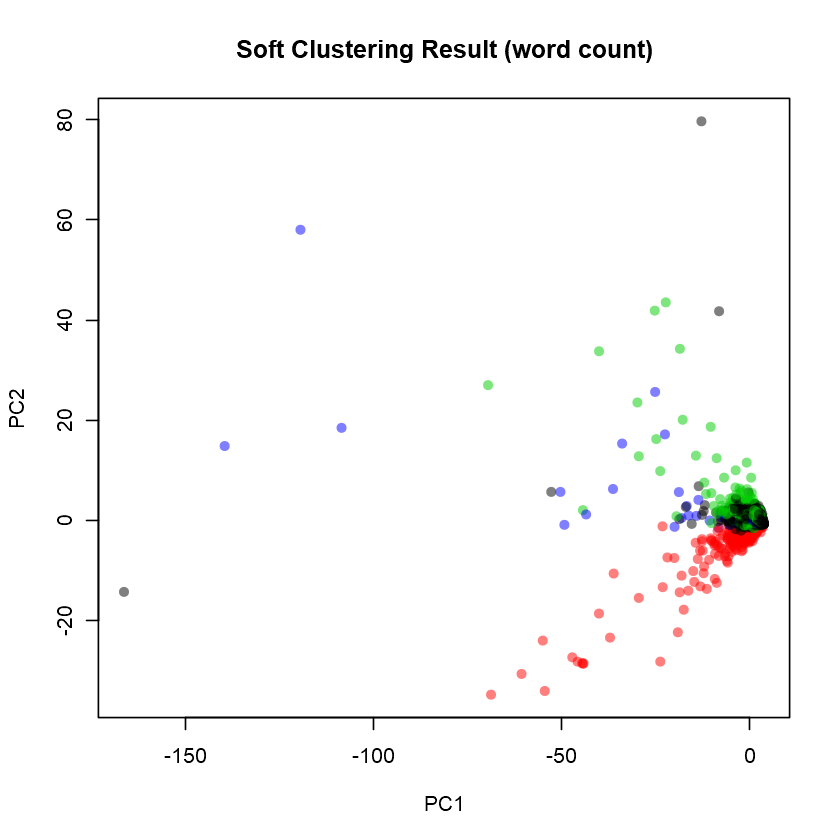

In [11]:
## perform pca
p.comp <- prcomp(m)

## plot the softclustering outcome
plot(p.comp$x, col=adjustcolor(max.soft.class, alpha=0.5), pch=16, main='Soft Clustering Result (word count)')

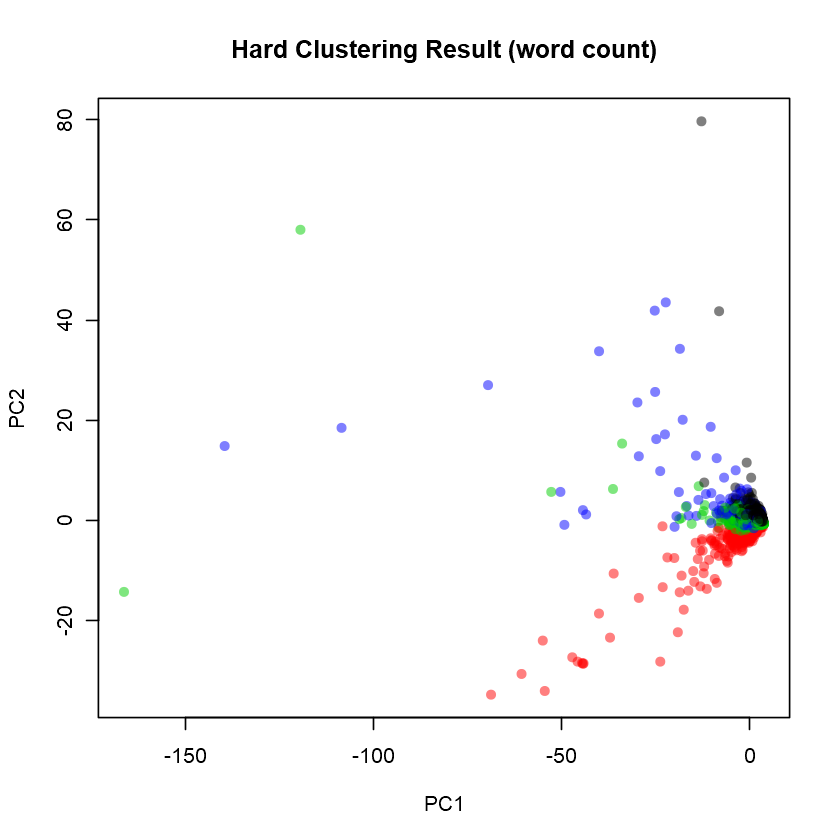

In [12]:
## plot the hardclustering outcome
plot(p.comp$x, col=adjustcolor(max.hard.class, alpha=0.5), pch=16, main='Hard Clustering Result (word count)')

Although an attempt has been made to make classes correspond to each other in the soft and hard clustering algorithms through a reordering of the posterior classes, only the "red" class above stands out clearly as unique. There is overlap between the other 3 classes that has not been separated out based on clustering over word stems.  Looking at the original labels visualised over PCA primary features (below), it can be seen that both clustering approaches do not correspond directly to the original labels.  There is not clear separation of classes over the word stem feature vectors, so other types of features need to be investigated to enable clear clustering.

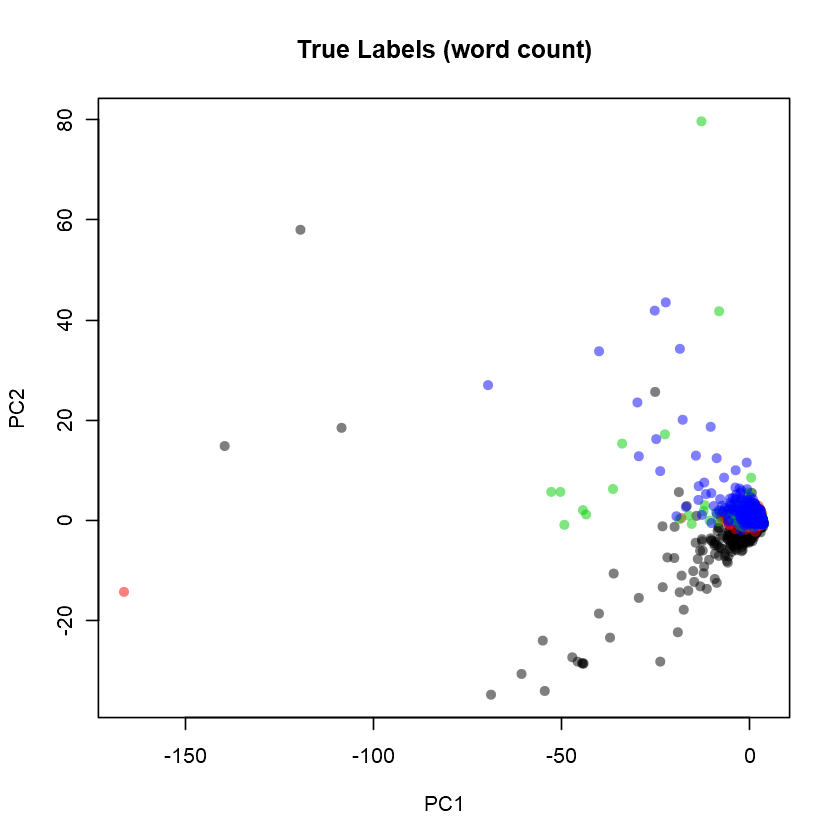

In [13]:
## plot the original labels to compare with the previous plot
plot(p.comp$x, col=adjustcolor(as.numeric(factor(labels)), 0.5), pch=16, main='True Labels (word count)')

# Part B. Neural Network vs. Perceptron
In this part, you apply a 3-layer Neural Network on a synthetically generated data to compare its performance with Perceptron. Here, we are looking for your explanation about the differences between perceptron and NN that leads to different results.
## Question 2 [Neural Network’s Decision Boundary, 30 Marks]
1\. Load __Task3B_train.csv__ and Task3B_test.csv sets, plot the training data with classes are marked with different colors, and attach the plot to your report.

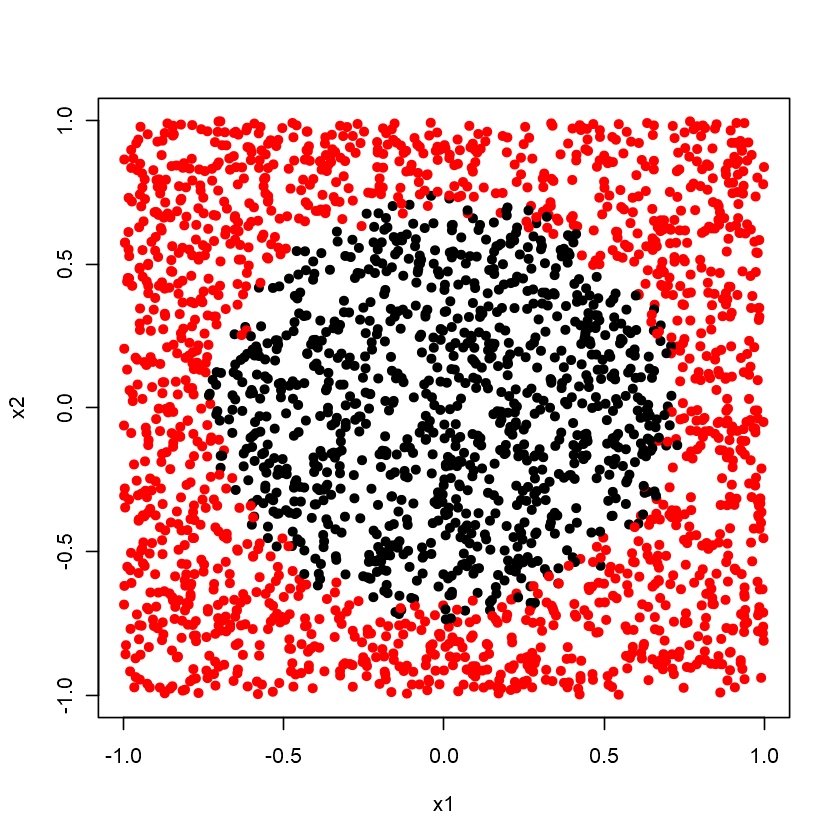

In [14]:
train.data <- read.csv("../Task3B_train.csv")
train.data <- train.data[complete.cases(train.data), ]
train.features <- train.data[, 1:2]
train.labels <- train.data[, 3]

test.data <- read.csv("../Task3B_test.csv")
test.data <- test.data[complete.cases(test.data), ]
test.features <- test.data[, 1:2]
test.labels <- test.data[, 3]

plot(train.features, pch=16, col=as.numeric(factor(train.labels)))

2\. Run the implementations of Perceptron given to you in Activity 3.1, calculate the test error, and plot the test data while the points are coloured with their estimated class labels; attach the pdf to your report.


In [15]:
# creates the Phi matrix, setting X0 to 1
project_phi <- function(train.data) {
    return(as.matrix(cbind('X0'=1, train.data)))
}

perceptron <- function(features, labels, c0='1', c1='-1', eta=0.01, epsilon=0.001, tau.max=100) {
    train.len <- nrow(features)
    ## Basis function (Step 1)
    Phi <- project_phi(features)
    
    T <- ifelse(labels == c0, eval(parse(text=c0)), eval(parse(text=c1))) # Convention for class labels

    W <- matrix(, nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
    W[1,] <- runif(ncol(Phi)) # Random initial values for weight vector

    error.trace <- matrix(0, nrow=tau.max, ncol=1) # Placeholder for errors
    error.trace[1] <- sum((Phi %*% W[1,])*T < 0) / train.len*100 # record error for initial weights

    tau <- 1                  # iteration counter
    terminate <- FALSE        # termination status
    
    # Main Loop (Step 2):
    while(!terminate) {
        # resuffling train data and associated labels:
        train.index <- sample(1:train.len, replace = FALSE)
        Phi <- Phi[train.index, ]
        T <- T[train.index]
        
        for (i in 1:train.len) {
            if (tau == tau.max) {break}
            # look for misclassified samples
            if ((W[tau,] %*% Phi[i,])*T[i] < 0) {
                # update tau counter
                tau <- tau + 1

                # update the weights
                W[tau, ] <- W[tau-1, ] + eta * Phi[i, ] * T[i]

                # update the records (training error)
                error.trace[tau] <- sum((Phi %*% W[tau, ])*T < 0) / train.len*100
            } 
        }

        # decrease eta:
        eta <- eta * 0.99
        # recalculate termination conditions
        terminate <- (tau >= tau.max) |
            (abs(sum((Phi %*% W[tau,])*T < 0 ) / train.len - sum((Phi %*% W[tau-1,])*T < 0) / train.len) <= epsilon)

    }
    
    # cut the empty part of the matrix (when the loop stops before tau == tau.max)
    W <- W[1:tau, ]
    return(W[tau, ])
}

In [16]:
predict <- function(features, weights, c0='1', c1='0') {
    predictions <- project_phi(features) %*% weights > 0
    return (ifelse(predictions, eval(parse(text=c0)), eval(parse(text=c1))))
}

trained.weights <- perceptron(train.features, train.labels, c0='1', c1='-1', eta=0.01, epsilon=0.001, tau.max=100)
trained.weights

[1] 0.02239440 0.09441106 0.09929293

In [17]:
test.results <- data.frame(x1 = test.features$x1, x2 = test.features$x2,
                           y = test.labels, y_predict = predict(test.features, trained.weights))
head(test.results)

x1,x2,y,y_predict
0.4973951,-0.5492695,1,1
0.2139925,0.6141635,0,1
-0.4656182,0.5093878,1,1
-0.1380630,0.8841224,1,1
0.6593270,0.3378901,1,1
0.6670054,0.6012369,1,1


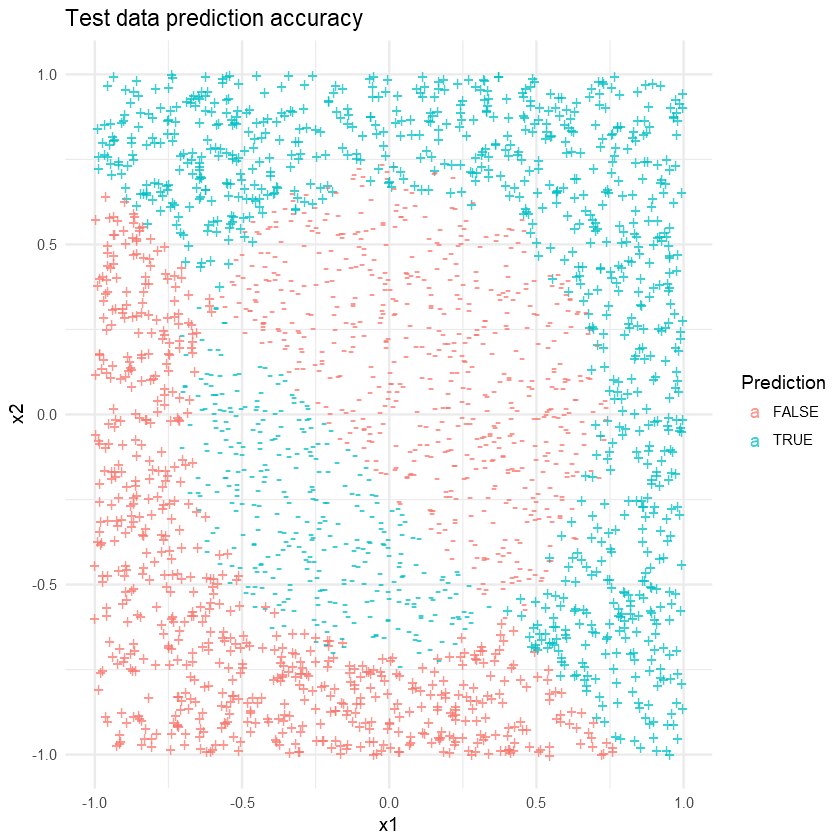

In [18]:
# Plot test results
ggplot(data=test.results, aes(x=x1, y=x2, label=ifelse(y==0, '-', '+'), color=factor(y == y_predict))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction')) +
    ggtitle('Test data prediction accuracy') +
    theme_minimal()


***Figure 2.1*** Learning outcome for the perceptron classifier based on the test data. A linear decision boundary is discernible running diagonally from top left to bottom right of the plot.  Given the circular nature of the decision boundary, the perceptron clearly fails in its classification attempt.

In [19]:
# Obtain the accuracy of test and training datasets
train.accuracy <- sum(train.labels == predict(train.features, trained.weights)) / length(train.labels) * 100
test.accuracy <- sum(test.results$y == test.results$y_predict) / nrow(test.results) * 100
cat("Perceptron training set accuracy: ", (train.accuracy), "%\n")
cat("Perceptron test set accuracy: ", (test.accuracy), "%")

Perceptron training set accuracy:  49.52 %
Perceptron test set accuracy:  48.2 %

3\. Run the 3-layer Neural Network given to you in Activity 5.1 with different values of K (i.e, number of units in the hidden layer) and record testing error for each of them; plot the error vs K and attach it to your report. Based on this plot, find the best K and the corresponding model, then plot the test data while the points are colored with their estimated class labels using the best model that you have selected.

In [20]:
# Use h2o for neural network training
options(warn=-1)
library(h2o)
# If there is a proxy: proxy.old <- Sys.getenv('http_proxy'); Sys.setenv('http_proxy'='');
# You may need to change the h2o.inint parameter values
localH2O =  h2o.init(nthreads = -1, port = 54321, max_mem_size = '6G', startH2O = TRUE)

# load test and train data
train.data.h2o <- na.omit(h2o.importFile('../Task3B_train.csv'))
test.data.h2o <- na.omit(h2o.importFile('../Task3B_test.csv'))
train.data.h2o[, 3] <- as.factor(train.data.h2o[, 3])
test.data.h2o[, 3] <- as.factor(test.data.h2o[, 3])


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 hours 32 minutes 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.20.0.4 
    H2O cluster version age:    5 days  
    H2O cluster name:           H2O_started_from_R_rmg_zib963 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   5.07 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.4.0 (2017-04-21) 

  |======================================================================| 100%
  |======================================================================| 100%


We now train 20 neural network models with a single hidden layer on the same data as used to train the perceptron above. The number of units in the hidden layer will vary from 1 to 20.

In [21]:
# This step may take a few minute to complete!
K <- 1:20  # range of number of hidden neurons

# initialise dataframe to store model evaluation data
nn.model.evaluation <- data.frame(
    k=rep(0, length(K)), train.accuracy=rep(0, length(K)), test.accuracy=rep(0, length(K)))

best.prediction <- NULL
best.accuracy <- 0  # worst possible accuracy for initialisation
best.k <- NULL

# loop over different number of units in the hidden layer of neural network to learn a suite of models
for (k in K) {
    mdl <- h2o.deeplearning(    
        y = 3,                  # y is the 3rd column
        training_frame = train.data.h2o, # specify the frame (imported file)    
        hidden = c(k),          # number units in the hidden layer
        epochs = 100,           # maximum number of epochs  
        activation = 'Tanh'     # activation function 
    )
    
    # use learned model for k hidden units to predict outcomes for train and test data
    test.pred <- h2o.predict(mdl, test.data.h2o)$predict
    train.pred <- h2o.predict(mdl, train.data.h2o)$predict
    
    # record train and test results and their accuracy
    test.results <- cbind(as.data.frame(test.data.h2o), predict=as.matrix(test.pred))
    train.results <- cbind(as.data.frame(train.data.h2o), predict=as.matrix(train.pred))
    accuracy.test <- sum(test.results$y == test.results$predict) / nrow(test.results)
    accuracy.train <- sum(train.results$y == train.results$predict) / nrow(train.results)
    
    nn.model.evaluation[k, ] <- c(k, accuracy.train, accuracy.test)
    
    # Find and record best k and test results
    if (accuracy.test > best.accuracy) {
        best.accuracy <- accuracy.test
        best.prediction <- test.results
        best.k <- k
    }
}

cat("The best choice of k is", best.k, ", with a validation set accuracy of", (best.accuracy * 100), "%\n")

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

The best choice of k is 17 , with a validation set accuracy of 95.64 %


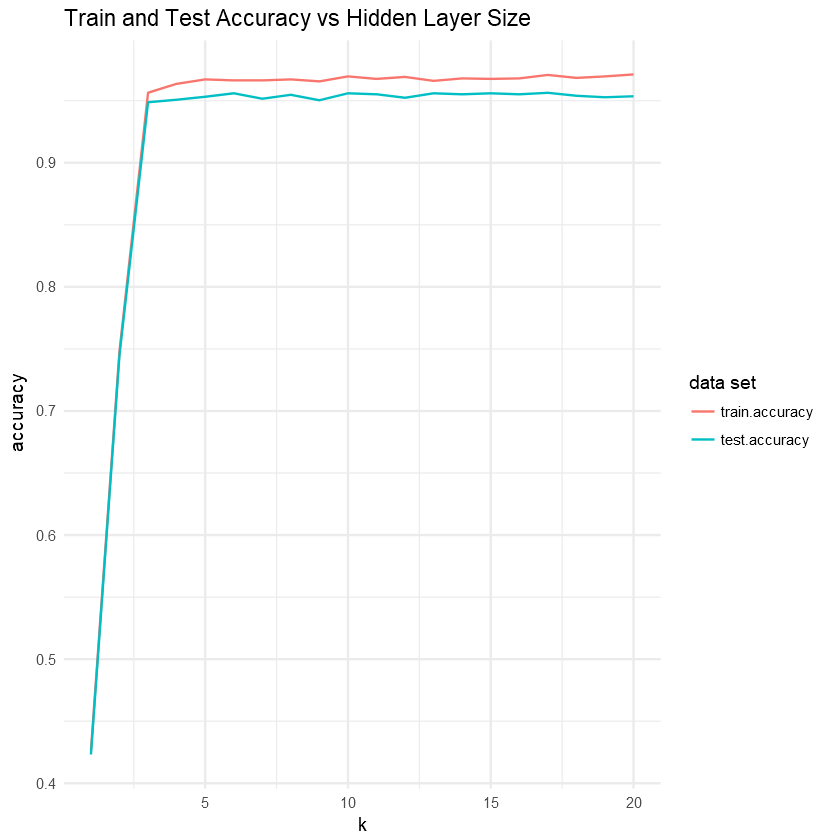

In [22]:
# reshape data for plotting
eval.m <- melt(nn.model.evaluation, id='k')
names(eval.m) <- c('k', 'set', 'accuracy')

# plot test and training accuracy:
ggplot(data = eval.m, aes(x = k, y = accuracy, color = factor(set))) + geom_line() +
    scale_color_discrete(guide = guide_legend(title = 'data set')) + 
    ggtitle('Train and Test Accuracy vs Hidden Layer Size') + theme_minimal()


4\. In a table, report the error rates obtained by the perceptron and all variants of NN. Then bold the best model (with minimum error).


In [23]:
cat('\nMODEL\t\t', 'TRAIN\t', 'TEST')
cat('\nperceptron\t', train.accuracy, '\t', test.accuracy)
for (k in K) {
    if (k == best.k) {
        cat('\n***', 'NN k =', k, '\t', nn.model.evaluation[k, ]$train.accuracy*100,
            '\t', nn.model.evaluation[k, ]$test.accuracy*100, '***')
    }
    else {
        cat('\n', 'NN k =', k, '\t', nn.model.evaluation[k, ]$train.accuracy*100,
            '\t', nn.model.evaluation[k, ]$test.accuracy*100)
    }
}


MODEL		 TRAIN	 TEST
perceptron	 49.52 	 48.2
 NN k = 1 	 42.64 	 42.32
 NN k = 2 	 74.84 	 74.52
 NN k = 3 	 95.64 	 94.88
 NN k = 4 	 96.36 	 95.08
 NN k = 5 	 96.72 	 95.32
 NN k = 6 	 96.64 	 95.6
 NN k = 7 	 96.64 	 95.16
 NN k = 8 	 96.72 	 95.48
 NN k = 9 	 96.56 	 95.04
 NN k = 10 	 96.96 	 95.6
 NN k = 11 	 96.76 	 95.52
 NN k = 12 	 96.92 	 95.24
 NN k = 13 	 96.6 	 95.6
 NN k = 14 	 96.8 	 95.52
 NN k = 15 	 96.76 	 95.6
 NN k = 16 	 96.8 	 95.52
*** NN k = 17 	 97.08 	 95.64 ***
 NN k = 18 	 96.84 	 95.4
 NN k = 19 	 96.96 	 95.28
 NN k = 20 	 97.12 	 95.36

In this table it can be seen that except for low values of $k$, the neural network provides test accuracies in the vicinity of 95% or above. The perceptron however has accuracy less than 50%, and there is little difference between training and test accuracies (49.5 versus 48.2).

For $k \gt 4$, improvement in accuracy for the neural network varies little, suggesting that although the test accuracy for $k = 5$ is marginally less than for the absolute best of $k = 17$, the $k = 5$ model could be the preferred model due to it being the one with the least parameters to fit, i.e. it is the simplest model with very good performance.

[1] 0


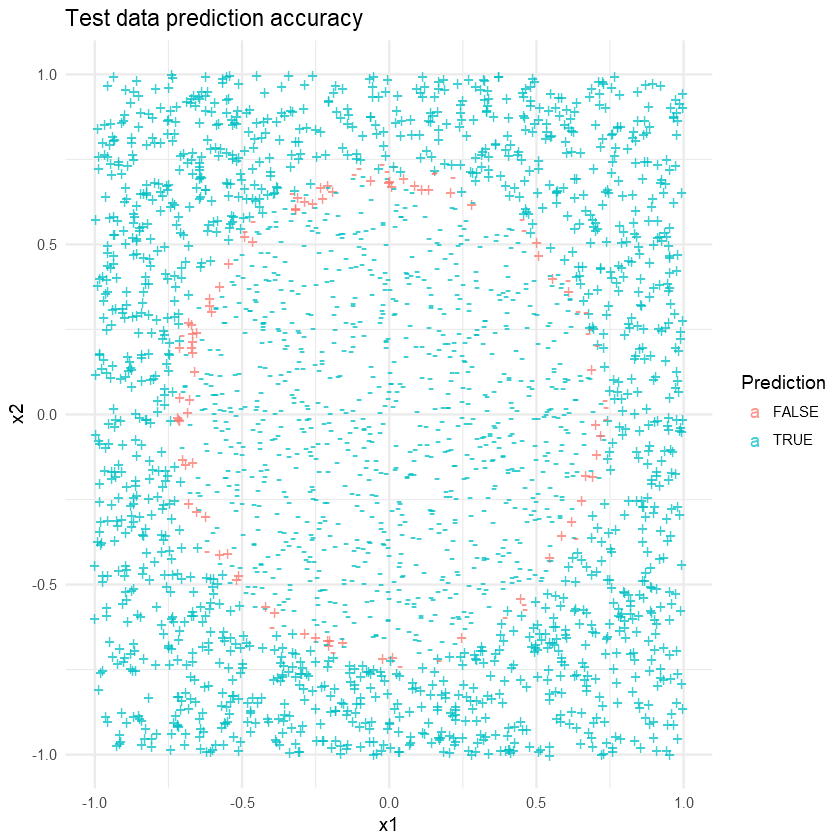

In [24]:
# Plot the data and color them differently if they are classified correctly or incorrectly
# Plot test results
ggplot(data=best.prediction, aes(x=x1, y=x2, label=ifelse(y==0, '-', '+'), color=factor(y == predict))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction')) +
    ggtitle('Test data prediction accuracy') +
    theme_minimal()

h2o.removeAll()  # free up some memory for the next part

***Figure 2.2*** Learning outcome for the best neural network classifier based on the test data. The circular decision boundary has been well-captured, with only a few misclassifications around the boundary (point marked in red).

5\. Explain the reason(s) responsible for such difference between perceptron and a 3-layer NN. Providing references and using diagrams are recommended.

__Hint:__ Look at the plots and think about the model assumptions.

The reason the perceptron performs so poorly on this data set (test accuracy of 48.2%) is that by construction it can only learn a linear decision boundary.  The perceptron is guaranteed to find a perfect parameter vector if the classes are linearly separable, though it is possible it may take too long to converge (Alexandria Ch 3.2).  With linearly separable classes however there will usually be many possible perfect linear decision boundaries.  The attempt by the perceptron to learn a linear decision boundary is clear in Figure 2.1 for the perceptron classification outcome.  In the current example, clearly the boundary is very far from linear (i.e. approximately circular). 

The neural network models are inheritantly non-linear by design, and so can capture complex decision boundaries in the data.  This is clear in Figure 2.2, where only a few points (marked in red) near the decision boundary are misclassified.

A perceptron is very quick to run and has few parameters to learn, so can be a good choice of classifier for simple linearly separable data sets.  In fact, the perceptron is effectively like a single unit of a neural network with a step activation function (Alexandria Ch 5.1). Neural networks usually use continously differentiable activation functions such as the sigmoid, which enable robust algorithms for traversing the weight space and seeking local optima of the cost function for training.  For data sets such as the current example, we need a more complex model to separate the classes.  The neural network models, which are sometimes known as multi-layer perceptrons, are very flexible and able to handle such a highly non-linear decision boundary.

# Part C. Self-Taught Learning
In this part, you implement self-taught learning for Neural Network using the Autoencoder that provided in Activity 5.2 and the 3-layer NN from Activity 5.1.
## Question 3 [Self Taught Neural Network Learning, 30 Marks]

__Hint.__ Since the dataset for this task is large and high-dimensional, running the whole
experiments several times is very time consuming. Therefore, it is recommended to only use a small portion of your data when you develop or debug your code.

__Hint.__ If you can combine Step II and V (so learn each autoencoder only once), you may save a great portion of the execution time.

__Hint.__ If you don’t see the expected behaviour in your plots, you may need to check that the data is clean, i.e. it does'nt have NA entries, it’s normalised etc. Moreover, you may need to check that your implementation of the model and training/decoding algorithms is correct.

1\. Load __Task3C_labeled.csv__, __Task3C_unlabeled.csv__ and __Task3C_test.csv__ data sets and required libraries (e.g., H2O). __Note__ that we are going to use __Task3C_labeled.csv__ and __Task3C_unlabeled.csv__ for training the autoencoder. We are going to use Task3C_labeled.csv for training the classifier. Finally, we evaluate the trained classifier on the test Task3C_test.csv.

In [25]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html

error.rate <- function(Y1, T1) {
    if (nrow(Y1) != nrow(T1)) {
        stop('error.rate: size of true labels and predicted labels mismatch')
      }
      return (sum(T1 != Y1) / nrow(T1))
}

##########################


# 1. Load the data
labeled.frame <- h2o.importFile(path = '../Task3C_labeled.csv', sep=',')
test.frame <- h2o.importFile(path = '../Task3C_unlabeled.csv', sep=',')
unlabeled.frame <- h2o.importFile(path = '../Task3C_test.csv', sep=',')

# Drop NAs, scale, and change data type as necessary
labeled.frame <- na.omit(labeled.frame)
labeled.frame[, 1] <- as.factor(labeled.frame[, 1])
labeled.frame[, 2:ncol(labeled.frame)] <-
    labeled.frame[, 2:ncol(labeled.frame)] / max(labeled.frame[, 2:ncol(labeled.frame)])

#unlabeled.frame[, 1] <- NA
unlabeled.frame <- na.omit(unlabeled.frame)
unlabeled.frame[, 2:ncol(unlabeled.frame)] <-
    unlabeled.frame[, 2:ncol(unlabeled.frame)] / max(unlabeled.frame[, 2:ncol(unlabeled.frame)])

test.frame <- na.omit(test.frame)
test.frame[, 1] <- as.factor(test.frame[, 1])
test.frame[, 2:ncol(test.frame)] <-
    test.frame[, 2:ncol(test.frame)] / max(test.frame[, 2:ncol(test.frame)])

# combine feature data from labelled and unlabelled data for complete training set
train.frame <- h2o.rbind(labeled.frame[, -1], unlabeled.frame[, -1])

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


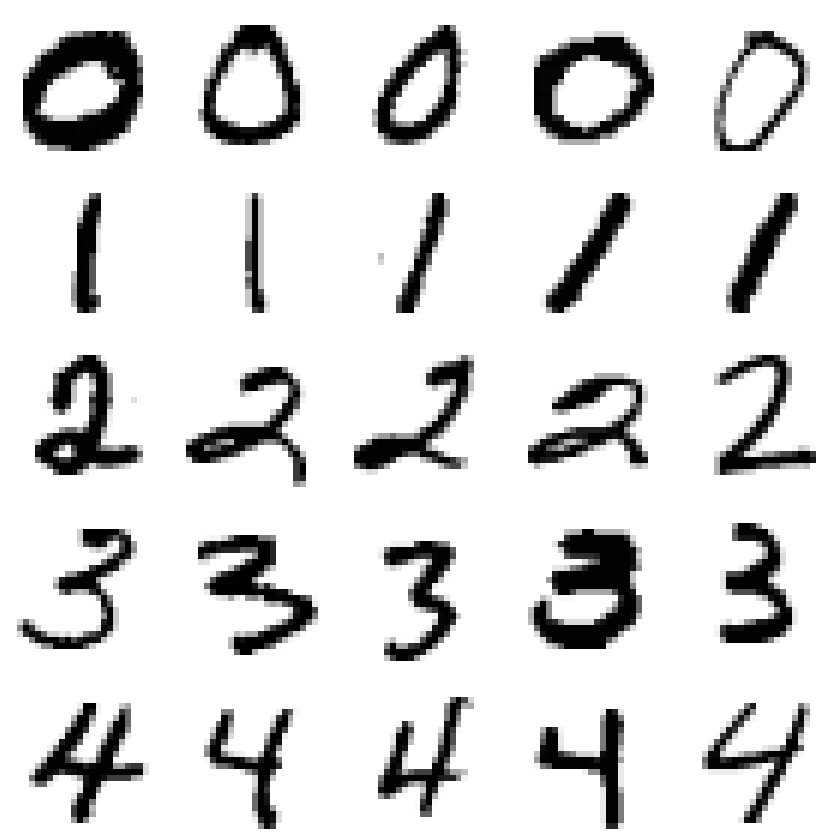

In [26]:
# visualise some samples
par(mfrow = c(5,5), mai = c(0,0,0,0))
for (i in 1:25) {
  y = as.matrix(labeled.frame[i, 2:785])
  dim(y) = c(28, 28)
  image(y[, nrow(y):1], axes = FALSE, col = gray(255:0 / 255))
}

2\. Build an autoencoder (similar to Activity 5.2) with only one hidden layer and change the number of its neurons from 2 to 50.

3\. For each model in Step II, calculate and record the reconstruction error which is simply the average (over all data points while the model is fixed) of Euclidean distances between the input and output of the autoencoder (you can simply use “h2o.anomaly()” function). Plot these values where the x-axis is the number of units in the middle layer and the y-axis is the reconstruction error. 

4\. Use the 3-layer NN from Activity 3.1 or “h2o.deeplearning” function (make sure you set “ autoencoder = FALSE”) build a model with 10 units in the hidden layer. Then, calculate and record the test error.

5\. Build augmented self-taught networks using the models learnt in Step II. For each model:
   1. Add the output of the middle layer as extra features to the original featureset, 
   2. Train a 3-layer NN (similar to Step IV) using all features (original + extra).Then calculate and record the test error.

In [27]:
# initialise classification error storage
errors <- data.frame(features = c(784, 786:(784+50)), error = rep(0, 50))

# 4. Build a classifier without using the autoencoder as a reference
NN.model.classifier = h2o.deeplearning(    
    x = 2:785,            # select all pixels
    y = 1,                # label is the first column
    training_frame = labeled.frame, # specify the frame (imported file)    
    hidden = c(10),       # a 10-unit hidden layer
    epochs = 100,         # maximum number of epochs  
    activation = 'Tanh',  # activation function
    autoencoder = FALSE   # we are building a classifier, not an autoencoder
)

# the classification error of the unaugmented neural network
ordinary.classification.error <- error.rate(h2o.predict(NN.model.classifier, test.frame)$predict, test.frame[, 1])
errors[errors$features == 784, 2] <- ordinary.classification.error
cat("Classification error without augmented features: ", ordinary.classification.error)

  |======================================================================| 100%
  |======================================================================| 100%
Classification error without augmented features:  0.23

In [28]:
# This step may take a few minutes to run

# Initialise storage for reconstruction error
reconstruction.error <- data.frame(k = 2:50, error = rep(0, 49))
# For autoencoder hidden layer size of k...
for (k in 2:50) {
    # Build an autoencoder using the labeled and unlabeled datasets...
    NN.model = h2o.deeplearning(    
        x = 1:784,                     # select all pixels
        training_frame = train.frame,  # specify the frame (imported file)    
        hidden = c(k),                 # k units in one layer
        epochs = 100,                  # maximum number of epochs  
        activation = 'Tanh',           # activation function
        autoencoder = TRUE             # is it an autoencoder? Yes!
    )
    # reconstruction error is the Euclidean distance between the input and output of the autoencoder
    reconstruction.error[reconstruction.error$k==k, 2] <- mean(h2o.anomaly(NN.model, train.frame))

    # Extract the middle layer for the labeled data set...
    middle.layer <- h2o.deepfeatures(NN.model, labeled.frame, layer=1)
    # Augment the features of the labeled data set with the learnt features...
    new.features <- h2o.cbind(labeled.frame, middle.layer)

    # Train a new classifier using the augmented features...
    NN.model.classifier = h2o.deeplearning(    
        x = 2:(785+k),                 # select all pixels
        y = 1,                         # label is the first column
        training_frame = new.features, # specify the frame (newly constructed features)  
        hidden = c(10),                # a 10-unit hidden layer
        epochs = 100,                  # maximum number of epochs  
        activation = 'Tanh',           # activation function
        autoencoder = FALSE            # training a new classifier, not an autoencoder
    )

    # Calculate and record the classification error...
    errors[errors$features == 784 + k, 2] <-
        error.rate(h2o.predict(NN.model.classifier, test.frame)$predict, test.frame[, 1])
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

6\. Plot the error rates for the 3-layer neural networks from Step IV and V while the x-axis is the number of features and y-axis is the classification error.

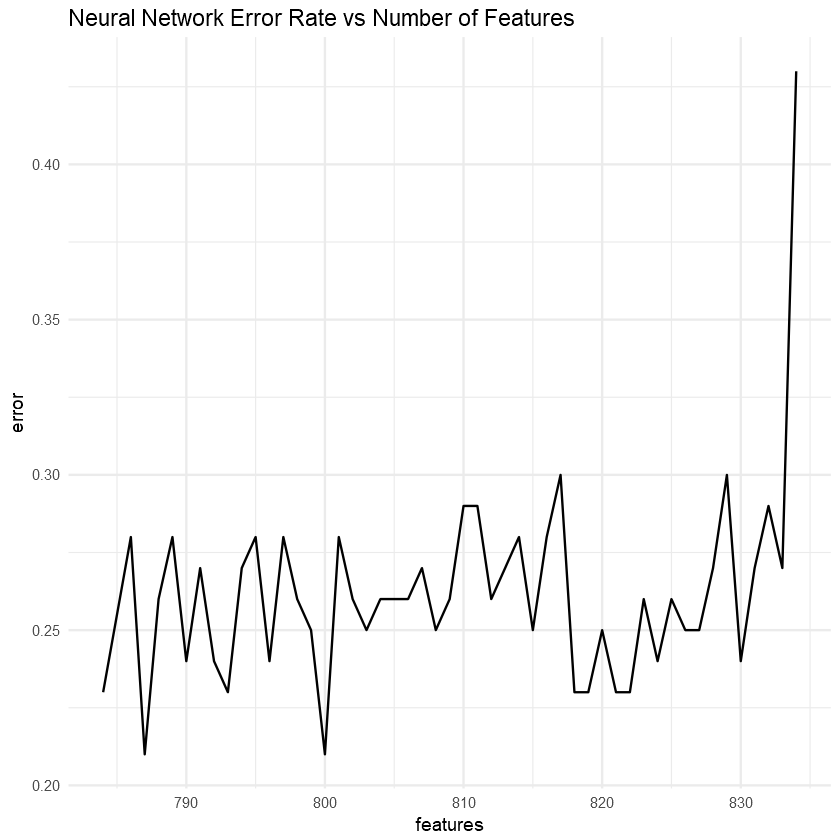

In [29]:
# plot error rates for set of trained NNs vs number of features:
ggplot(data = errors, aes(x = features, y = error)) + geom_line() +
    ggtitle('Neural Network Error Rate vs Number of Features') + theme_minimal()


7\. Report the optimum number(s) of units in the middle layer of the autoencoder in terms of the reconstruction and misclassification errors.

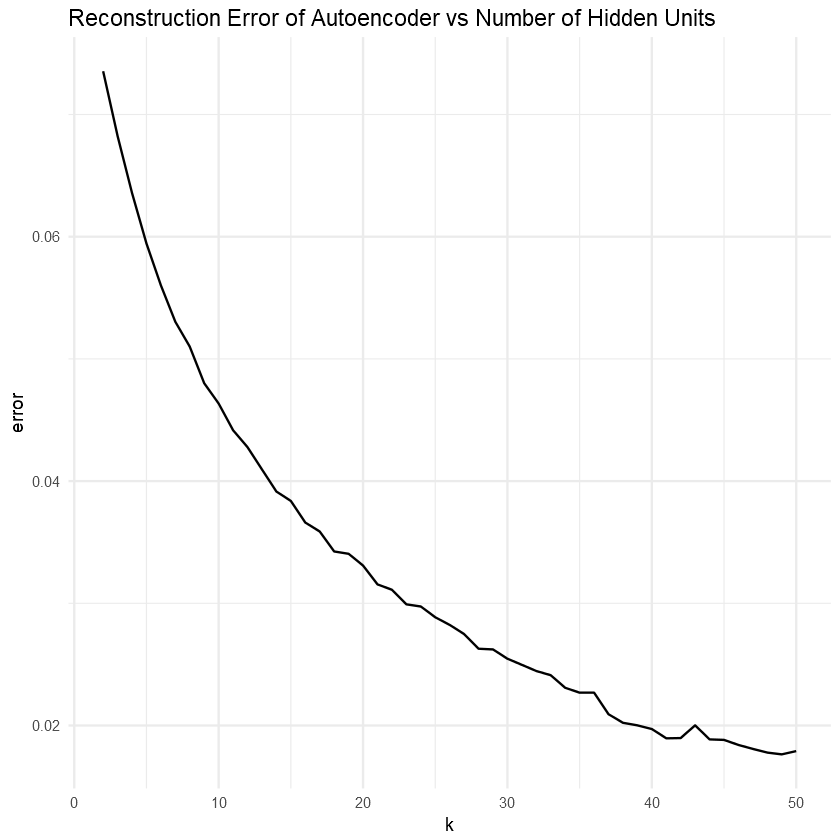

In [30]:
# plot error rates for set of trained NNs vs number of features:
ggplot(data = reconstruction.error, aes(x = k, y = error)) + geom_line() +
    ggtitle('Reconstruction Error of Autoencoder vs Number of Hidden Units') + theme_minimal()


In [31]:
head(errors)

features,error
784,0.23
786,0.28
787,0.21
788,0.26
789,0.28
790,0.24


In [32]:
cat('\nMaximum error:\n')
errors[which.max(errors$error), ]
cat('\nMinimum error:\n')
errors[which.min(errors$error), ]


Maximum error:


,features,error
50,834,0.43



Minimum error:


,features,error
3,787,0.21


In terms of the autoencoder's reconstruction error, we see a steady decline from $k = 1$ to $k = 50$, with the error appearing to level off close to $k = 50$.  This indicates that the original feature dimension of 784 (28 by 28 pixels) can be reduced to around 50 nonlinear principal components, which is a significant reduction in the dimensionality of the data set.  It is however noteworthy that even for small values of $k$, say $k \sim 5$, the reconstruction error is already quite small - around 0.06.  Thus for slightly worse reconstruction performance, we could employ even a considerably lower dimension autoencoder.

8\. Comparing the plot from Step III and VI, do you observe any relation between the reconstruction error and misclassification error? Explain your findings.

There does not appear to be any relation between the reconstruction error and the misclassification error - the misclassification error seems to fluctuate randomly between different numbers of extra features.  We also note that while developing and testing this code, different maximum error occurred for different numbers of features (not just 834 features as shown in the above plot). There also tended to be one particular number of features that produced considerably greater error than the others, but this appeared to be random and changed every time the code was run.  This indicates that the errors are very sensitive to the initial random seeds employed, and are essentially not reproducible.

This behaviour can be explained as follows.  The extra features learned from the autoencoders are a complex non-linear combination of the original 784 features.  They are thus highly correlated with the original features, and do not provide any substantially new information to train the model.  This can be seen from the fact that the original neural network trained on $k = 784$ features has a lower error than many of the higher dimensional models.  As is well known from linear models, too many features actually tend to degrade the prediction performance of a model.  The real value of the autoencoders that have been trained is to ***replace*** the original features with a considerably lower dimension feature space.  This then provides a predictive model that is simpler and faster to execute, and performs almost as well as the model trained on all the original features.

...